# Setup

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_machine_learning.utils import algorithm_globals
from scipy.optimize import minimize
from numpy.typing import NDArray
from qiskit_aer import AerSimulator
from tqdm import tqdm
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import QiskitRuntimeService

In [95]:
seed = 50

algorithm_globals.random_seed = seed
np.random.seed(seed)

In [96]:
num_inputs = 1 # num of features (p)
num_samples_train = 512 # num of instances (n)
batch_size = 4
num_samples_test = 8
test_batch_size = 4
num_params = 4
nb_iter = 4

In [97]:
observable = SparsePauliOp("ZII")

In [98]:
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)

In [99]:
print(backend)

<IBMBackend('ibm_kyiv')>


In [100]:
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

In [101]:
# Points between -2 and 2 on a single axis
X = 4 * algorithm_globals.random.random(num_samples_train) - 2  
X_test = 4 * algorithm_globals.random.random(num_samples_test) - 2

# Blue if between -1 and 1, red otherwise
Y = np.where((X >= -1) & (X <= 1), 1, -1)  # Y contains 1 and -1
Y_test = np.where((X_test >= -1) & (X_test <= 1), 1, -1)

# Ensure the arrays are of type float64
X = X.astype(np.float64)
Y = Y.astype(np.float64)
X_test = X_test.astype(np.float64)
Y_test = Y_test.astype(np.float64)

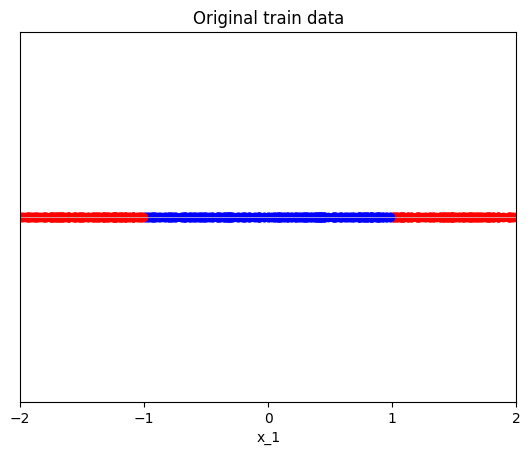

In [102]:
# On plot la distribution
for x_i, y_i in zip(X, Y):
    if y_i == 1:
        plt.plot(x_i, 0, "bo") 
    else:
        plt.plot(x_i, 0, "ro")

plt.axhline(0, color="lightgray", linewidth=0.5)
plt.title("Original train data")
plt.xlabel("x_1")
plt.xticks([-2, -1, 0, 1, 2])
plt.yticks([])
plt.xlim(-2, 2)
plt.show()

# Model

In [103]:
class QuantumModel() :
    def __init__(self, paramValues: NDArray[np.float64], X: NDArray[np.float64], Y: NDArray[np.float64], batch_size: int,
                  test_batch_size: int, backend, circuit = None, transpiledCircuit = None, shots = 1024,
                  parameterList = [Parameter("x1"), Parameter("x2"), Parameter("theta1"), Parameter("theta2"), Parameter("theta3"), Parameter("theta4")]) :
        
        self.paramValues: NDArray[np.float64] = paramValues
        self.X: NDArray[np.float64] = X
        self.Y: NDArray[np.float64] = Y
        self.batch_size: int = batch_size
        self.test_batch_size: int = test_batch_size
        self.shots: int = shots
        self.backend = backend
        self.parameterList = parameterList
        self.mappedObservable = None

        self.circuit = circuit
        self.transpiledCircuit = transpiledCircuit

    def updateParams(self, new_param_values: NDArray[np.float64]) :
        self.paramValues: NDArray[np.float64] = new_param_values

    def createCircuit(self) :

        qc = QuantumCircuit(3)

        qc.ry(self.parameterList[0], 1)
        qc.rx(self.parameterList[2], 1)
        qc.rx(self.parameterList[0], 1)
        qc.ry(self.parameterList[3], 1)
        qc.rx(self.parameterList[0], 1)
        qc.ry(self.parameterList[4], 1)
        qc.rx(self.parameterList[0], 1)
        qc.ry(self.parameterList[5], 1)
        qc.rx(self.parameterList[0], 1)

        qc.ry(self.parameterList[1], 2)
        qc.rx(self.parameterList[2], 2)
        qc.rx(self.parameterList[1], 2)
        qc.ry(self.parameterList[3], 2)
        qc.rx(self.parameterList[1], 2)
        qc.ry(self.parameterList[4], 2)
        qc.rx(self.parameterList[1], 2)
        qc.ry(self.parameterList[5], 2)
        qc.rx(self.parameterList[1], 2)

        qc.h(0)
        qc.cswap(0, 1, 2)
        qc.h(0)

        self.circuit = qc

    def transpileCircuit(self) :
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(self.circuit)

        self.transpiledCircuit = isa_circuit

        self.mappedObservable = observable.apply_layout(isa_circuit.layout)

    def fidelity(self, x1: np.float64, x2: np.float64) -> np.float64:

        parametersDict = {
            self.parameterList[0]: x1,
            self.parameterList[1]: x2,
            self.parameterList[2]: self.paramValues[0],
            self.parameterList[3]: self.paramValues[1],
            self.parameterList[4]: self.paramValues[2],
            self.parameterList[5]: self.paramValues[3]
        }

        assert self.transpiledCircuit is not None, "The transpiled circuit must be defined"
        assert self.mappedObservable is not None, "The mapped observable must be defined"

        boundCircuit = self.transpiledCircuit.assign_parameters(parametersDict)

        job = estimator.run([(boundCircuit, [self.mappedObservable])])

        result = job.result()[0].data.evs[0]

        return result

    def trace(self, class1: NDArray[np.float64], class2: NDArray[np.float64]) -> np.float64 :
        """
        Compute the trace of the density matrix of class1 multiplied by the density matrix of class2

        class1, class2 are arrays of data corresponding to each class
        """
        result = np.float64(0)


        for x1 in class1 :
            for x2 in class2 :
                result += self.fidelity(x1, x2)
        
        return result

    def Dhs(self) -> np.float64 :
        indices = np.random.choice(len(self.X), size=self.batch_size, replace=False)
        
        # Split the sampled data into two classes based on Y labels
        Xsample = self.X[indices]
        Ysample = self.Y[indices]
        
        Xpositive = Xsample[Ysample == 1]
        Xnegative = Xsample[Ysample == -1] 

        return self.trace(Xpositive,Xpositive) + self.trace(Xnegative, Xnegative) - 2*self.trace(Xpositive, Xnegative)

    def loss(self) -> np.float64 :
        return 1-0.5*self.Dhs()
    
    def xrhox(self, x: np.float64, class1: NDArray[np.float64]) -> np.float64 :
        result = np.float64(0)

        for x1 in class1 :
            result += self.fidelity(x, x1)
        
        return result
    
    def fidelityMeasurement(self, x: np.float64) -> np.float64 :
        indices = np.random.choice(len(self.X), size=self.test_batch_size, replace=False)

        Xsample = self.X[indices]
        Ysample = self.Y[indices]
        
        Xpositive = Xsample[Ysample == 1]
        Xnegative = Xsample[Ysample == -1] 

        return self.xrhox(x, Xpositive) - self.xrhox(x, Xnegative)
    
    def predict(self, x) :
        out = self.fidelityMeasurement(x)

        if out > 0 :
            return 1
        else :
            return -1
    
    def predictArray(self, X: NDArray[np.float64]) -> NDArray[np.float64] :
        return np.array([self.predict(x) for x in X])

In [104]:
initParams = np.zeros(num_params, dtype=np.float64)

qm = QuantumModel(initParams, X, Y, batch_size, test_batch_size, backend)

qm.createCircuit()
qm.transpileCircuit()

qm.transpiledCircuit.draw("mpl")

# Optimisation

In [105]:
def objectiveFunction(params_: NDArray[np.float64]) -> np.float64 :

    qm.updateParams(params_)
    loss = qm.loss()


    return loss


In [106]:

def train() :

    with tqdm(total=nb_iter) as pbar:
        def callback(xk):
            pbar.update(1)

        result = minimize(objectiveFunction, initParams, method="COBYLA", options={'maxiter': nb_iter}, callback=callback)

    return result

result = train()
print(result)


  0%|          | 0/4 [02:37<?, ?it/s]


KeyboardInterrupt: 

# Inference

In [ ]:
def computeAccuracy() :
    params = result.x
    qm.updateParams(params)

    testFidelities = np.array([qm.fidelityMeasurement(x) for x in X_test])

    corrects = np.sum(np.where(testFidelities > 0, 1, -1) == Y_test)
    total = len(Y_test)
    accuracy = corrects / total

    return corrects, total, accuracy

def printAccuracy() :
    corrects, total, accuracy = computeAccuracy()
    print(f"Corrects : {corrects} / {total}")
    print(f"Accuracy : {accuracy}")

printAccuracy() #random is 0.5 accuracy

c:\Users\sandr\Desktop\CACIB\QiskitCode\qiskitEnv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
c:\Users\sandr\Desktop\CACIB\QiskitCode\qiskitEnv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
c:\Users\sandr\Desktop\CACIB\QiskitCode\qiskitEnv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
c:\Users\sandr\Desktop\CACIB\QiskitCode\qiskitEnv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:186: UserWarning: The resil

Corrects : 5 / 8
Accuracy : 0.625


# Plots

In [91]:

def plotPredictionsOnTest(params: NDArray[np.float64]) :
    qm.updateParams(params)

    Y_predict = qm.predictArray(X_test)

    for i in range(len(X_test)) :
        if Y_predict[i] > 0 :
            plt.plot(X_test[i], 0, "bo")
        else :
            plt.plot(X_test[i], 0, "ro")

        # On entoure les instances mal classifiées en vert
        if Y_test[i] != Y_predict[i] :
            plt.scatter(X_test[i], 0, s=200, facecolors="none", edgecolors="g", linewidths=2)

    plt.axhline(0, color="lightgray", linewidth=0.5)

    plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=-1, color='gray', linestyle='--', linewidth=1)

    plt.title("Predicted test data")
    plt.xlabel("x_1")
    plt.xticks([-2, -1, 0, 1, 2])
    plt.yticks([])
    plt.xlim(-2, 2)
    plt.show()

### With optimized parameters

c:\Users\sandr\Desktop\CACIB\QiskitCode\qiskitEnv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
c:\Users\sandr\Desktop\CACIB\QiskitCode\qiskitEnv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
c:\Users\sandr\Desktop\CACIB\QiskitCode\qiskitEnv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
c:\Users\sandr\Desktop\CACIB\QiskitCode\qiskitEnv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:186: UserWarning: The resil

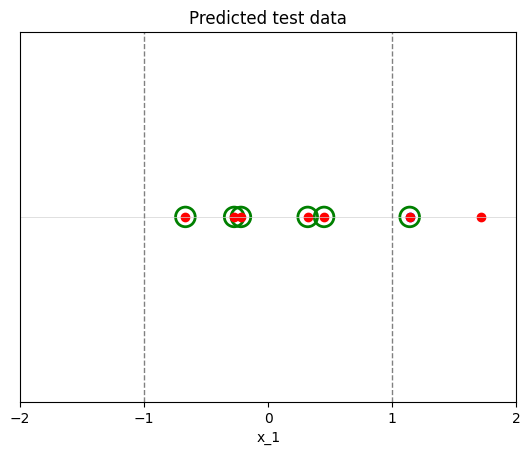

In [93]:
optimalParams = result.x

plotPredictionsOnTest(optimalParams)